In [1]:
from model.transformers import Encoder
import torch
import numpy as np
len_traj = 40
batch_size = 4
d_obj = 2
d_embed = 256 # embedding dimension
n_heads = 16
d_k = 16
d_hidden = 64
d_class = 4
n_layers = 6 # Encoder内含
if torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
encoder = Encoder(d_obj, d_embed, d_class, d_k, d_hidden, n_heads, n_layers)
x = torch.randn(30, 4, 2)
y, _ = encoder(x)
def mapping_qpsk (
    data
):
    _real = np.real(data)
    _imag = np.imag(data)

    if _real > 0 and _imag > 0:
        return 0
    if _real > 0 and _imag < 0:
        return 1
    if _real < 0 and _imag > 0:
        return 2
    else:
        return 3
    
def cross_entropy(y_true,y_pred):
    C=0
    # one-hot encoding
    for col in range(y_true.shape[-1]):
        y_pred[col] = y_pred[col] if y_pred[col] < 1 else 0.99999
        y_pred[col] = y_pred[col] if y_pred[col] > 0 else 0.00001
        C+=y_true[col]*torch.log(y_pred[col])+(1-y_true[col])*torch.log(1-y_pred[col])
    return -C

In [21]:
from rezero.transformer import RZTXEncoderLayer
import torch.nn as nn

class Stransformers(nn.Module):
    def __init__(self, d_obj, nhead, num_layer = 6, d_embed = 128, d_class = 4):
        super(Stransformers, self).__init__()
        self.embedding = nn.Linear(d_obj, d_embed)
        enc_layer = RZTXEncoderLayer(d_embed, nhead)
        self.encoder = nn.TransformerEncoder(enc_layer, num_layer)
        self.fc = nn.Linear(d_embed, d_class)

    def forward(self, x):
        y = self.embedding(x)
        y = self.encoder(y)
        y = self.fc(y)
        out = torch.log_softmax(y, dim = -1)
        return out



In [3]:
import torch
import numpy as np
from data_processing import *
import scipy.io as spio
from torch.nn import functional as F


Nr = 16
Nt = 16
carrier_num = 16
symbol_num = 1000
channel_num = 100

_channel = {}
_tau = list()
_fdoppler = list()
_Txsteering = list()
_Rxsteering = list()
_x = list()
_y = list()
_y_norm = list()
_y_norm_n = list()
h = list()

for i in range(1, channel_num+1):
    path = f'./MIMO_data/ISAC_QPSK_OFDM_{i}.mat'
    data = spio.loadmat(path)
    _tau.append(
        data['ISAC_data']['channel'][0][0]['time_delay'][0][0][0]
    )
    _fdoppler.append(
        data['ISAC_data']['channel'][0][0]['f_doppler'][0][0][0]
    )
    _Txsteering.append(
        data['ISAC_data']['channel'][0][0]['Tx_steeringangle'][0][0][0]
    )
    _Rxsteering.append(
        data['ISAC_data']['channel'][0][0]['Rx_steeringangle'][0][0][0]
    )
    _x.append(
        data['ISAC_data']['x'][0][0]
    )
    _y.append(
        data['ISAC_data']['y'][0][0]
    )
    _y_norm.append(
        data['ISAC_data']['y_norm'][0][0]
    )
    _y_norm_n.append(
        data['ISAC_data']['y_norm_n'][0][0]
    )
    h.append(
        data['ISAC_data']['h'][0][0]
    )

_channel['time_delay'] = _tau
_channel['doppler_shift'] = _fdoppler
_channel['_Txsteering'] = _Txsteering
_channel['_Rxsteering'] = _Rxsteering

x_mimo, _, y_mimo, h = np.array(_x), np.array(_y), np.array(_y_norm), np.array(h)
y_mimo_n = np.array(_y_norm_n)


# take the first carrier as an example

# y_lstm_isac = np.zeros(shape = (carrier_num, channel_num, symbol_num, Nr, 2))
# label_isac = np.zeros(shape = (carrier_num, channel_num, symbol_num))
# for n in range (carrier_num):
#     for i in range (channel_num):
#         for j in range (symbol_num):
#             label_isac[n, i, j] = mapping_qpsk (
#                 x[i, j, n]
#             )
#             for k in range (Nr):
#                 y_lstm_isac[n, i, j, k] = np.array(
#                     [
#                         np.real(y_norm_n[i, j, n, k]),
#                         np.imag(y_norm_n[i, j, n, k]),
#                     ]
#                 )







torch.Size([30, 4, 2])
(100, 1000, 16, 16)


In [5]:
print (x_mimo.shape)
print (y_mimo_n.shape)

y_isac, _ = complex2real_fDOM(y_mimo_n, carrier_num, Nr, symbol_num, channel_num)

_, label_isac = complex2real_fDOM(x_mimo, carrier_num, Nr, symbol_num, channel_num)

print (f'received data shape: {y_isac.shape}')
print (f'transmitted constellation shape: {label_isac.shape}')

(100, 1000, 16, 16)
(100, 1000, 16, 16)
received data shape: torch.Size([100, 1000, 16, 16, 2])
transmitted constellation shape: torch.Size([100, 1000, 16, 16])


In [22]:
y_isac_mimo = y_isac.permute(2, 0, 1, 3, 4)
label_isac_mimo = label_isac.permute(2, 0, 1, 3)


In [23]:
y_train, label_train = y_isac_mimo[0], label_isac_mimo[0]

y_train_1, label_train_1 = y_isac_mimo[15], label_isac_mimo[15]
print (f'training data shape: {y_train.shape}')
print (f'training label shape{label_train.shape}')

training data shape: torch.Size([100, 1000, 16, 2])
training label shapetorch.Size([100, 1000, 16])


In [16]:
import torch
from torch import nn

class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(
            input_size, hidden_size, bidirectional=True, num_layers = 3
        )
        self.fc = nn.Linear(hidden_size * 2, num_classes) # times 2 because of bidirection

    def forward(self, x):
        seq_len, batch_size, _ = x.size()
        h0 = torch.zeros(2*self.lstm.num_layers, batch_size, self.hidden_size).to(x.device) # 2 for bidirection 
        c0 = torch.zeros(2*self.lstm.num_layers, batch_size, self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])

        return out
# Parameters
input_size = 2 # input size for each LSTM cell (complex numbers)
hidden_size = 20 # hidden state size for LSTM cell
num_classes = 4 # number of classes for classification


In [17]:

# Instantiate the model
model = BiLSTM(input_size, hidden_size, num_classes)
# y_samples = torch.tensor(y_lstm_n, dtype = torch.float32).permute(0, 2, 1, 3)
# label = torch.tensor(x, dtype = torch.long)
# Example input: three sequences, each sequence is 4 complex numbers (each represented as a 2D vector)
# The dimensions are (sequence length, batch size, input size)
# x = torch.randn(30, 4, input_size)
# Forward pass

optimiser_transformers = torch.optim.Adam(
    enc.parameters(),
    lr = 0.001,
    weight_decay = 0.0001,
)
optimiser_lstm = torch.optim.Adam(
    model.parameters(),
    lr = 1e-3,
    weight_decay = 1e-4
)
loss = nn.CrossEntropyLoss()
import hiddenlayer as hl

canvasl = hl.Canvas()
historyl = hl.History()
window_size = 40
train_cnt = 0
acc_train_list = list()
acc_train_lstm_list = list()

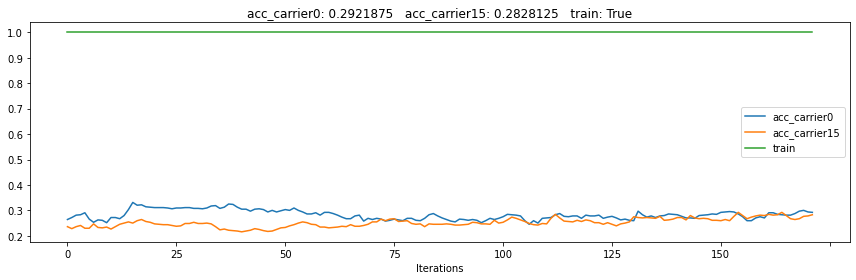

KeyboardInterrupt: 

In [27]:

import time
from matplotlib import pyplot as plt
canvasl = hl.Canvas()
historyl = hl.History()
input_size = 2 # input size for each LSTM cell (complex numbers)
hidden_size = 20 # hidden state size for LSTM cell
num_classes = 4 # number of classes for classification
window_size = 40
acc_list = list()
training_time =list()
for idx in range (10):
    
    start = time.time()
    train = True
    # Parameters


    enc_new= Stransformers(d_obj, n_heads)
    enc_lstm = BiLSTM(input_size, hidden_size, num_classes)

    _x = y_train[idx]
    _y= label_train[idx]

    _X = y_train_1[idx]
    _Y = label_train_1[idx]
    Loss = nn.CrossEntropyLoss()
    optimiser_pt = torch.optim.Adam(
        enc_new.parameters(),
        lr = 1e-3,
        weight_decay = 1e-4
    )

    cnt_print = 0
    for cnt in range (symbol_num - window_size + 1):
        _cnt  = cnt +1
        x = _x[cnt: cnt + window_size]
        y = _y[cnt: cnt + window_size]

        x_1 = _X[cnt: cnt + window_size]
        y_1 = _Y[cnt: cnt + window_size]

        # carrier 0
        Y = enc_new(x)
        _, predicted = torch.max(Y, 2)
        acc = (predicted == y).sum().item() / (window_size * Nt)

        # carrier 1
        Y_1 = enc_new(x_1)
        _, predicted = torch.max(Y_1, 2)
        acc_1 = (predicted == y_1).sum().item() / (window_size * Nt)

        historyl.log(
            cnt,
            acc_carrier0 = acc,
            acc_carrier15 = acc_1,
            train = train
        )
        canvasl.draw_plot([
            historyl['acc_carrier0'],
            historyl['acc_carrier15'],
            historyl['train']
        ])

        # decide whether the network requires training
        if train:
            optimiser_pt.zero_grad()
            Y = Y.permute(0, 2, 1)
            loss = Loss(Y, y)
            loss.backward()
            optimiser_pt.step()
        if acc > 0.9:
            if cnt_print == 0:
                end = time.time()
                _training = end - start
                training_time.append(_training)
                acc_list.append(_cnt)
                if (_cnt) % 100 == 0:
                    print (f'{_training:.2f} - - {_cnt}')
                # print (f'for channel index {idx}')
                # print (f'processing time for more than 90% is {end - start:.2f}')
                # print (f'required steps is {cnt+1}')
                cnt_print += 1
                train = False
                # break
        
            # break
    plt.savefig(f'./results/sub_carrier_test{idx}.png')
    break
    

In [13]:
acc_list = np.array(acc_list)
training_time = np.array(training_time)

[ 0  5 10 15 20]


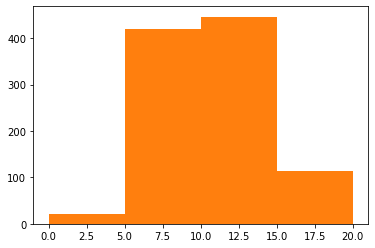

In [66]:
bin = [0, 5, 10, 15, 20]
_y_acc = plt.hist(acc_list, bins=bin)[0]
_x_acc = plt.hist(acc_list, bins=bin)[1]
print (_x_acc)

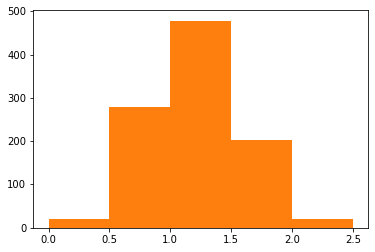

In [68]:
bin = [0, 0.5, 1, 1.5, 2, 2.5]
number_training_time = plt.hist(training_time, bins = bin)[0]
time_training = plt.hist(training_time, bins = bin)[1]

In [70]:
x_axis_training = [(time_training[i] + time_training[i+1])/2 for i in range (len(number_training_time))]
x_axis_step = [(_x_acc[i] + _x_acc[i+1])/2 for i in range (len(_y_acc))]

In [71]:
len(x_axis_step)

4

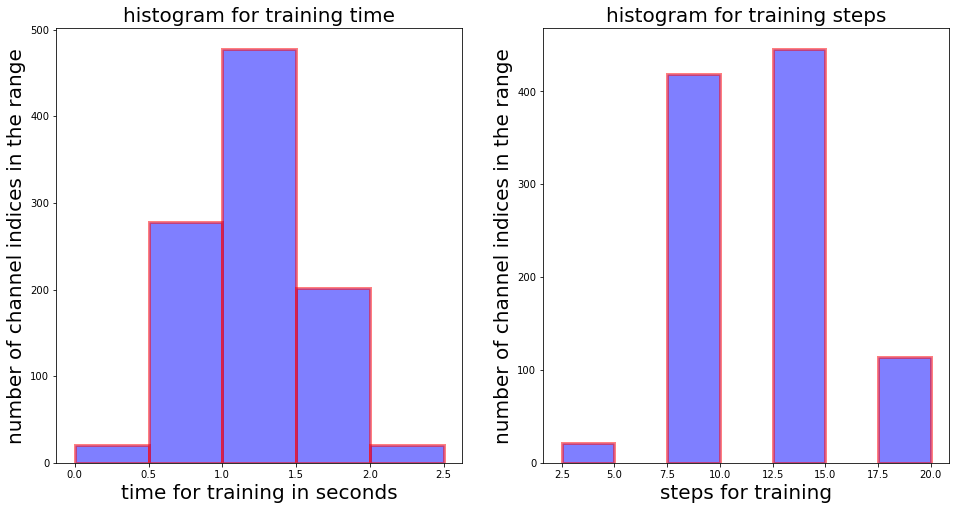

In [111]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
font = {
    'size': 20
}
ax1 = fig.add_subplot(121)
ax1.bar(
    x = x_axis_training,
    width=0.5, height = number_training_time,
    alpha = 0.5,
    color = 'blue',
    edgecolor = 'red',
    linewidth = 3
)
ax1.set_title('histogram for training time', fontdict=font)
ax1.set_xlabel('time for training in seconds', fontdict=font)
ax1.set_ylabel('number of channel indices in the range', fontdict = font)

ax2 = fig.add_subplot(122)
ax2.bar(
    x = x_axis_step,
    width = 2.5, height = _y_acc,
    alpha = 0.5,
    align='edge',
    color = 'blue',
    edgecolor = 'red',
    linewidth = 3
)
ax2.set_title('histogram for training steps', fontdict=font)
ax2.set_xlabel('steps for training',fontdict=font)
ax2.set_ylabel('number of channel indices in the range', fontdict = font)

plt.savefig ('./results/STransformers_2dB.png')
plt.show()

In [ ]:




# for epoch in range (10):

#     print (f'For Epoch {epoch+1}: ------------------')
#     for _y_train, _label_train in zip(
#         y_train[600:610], label_train[600:610]
#     ):
#         train_cnt += 1
#         acc_train = 0
#         acc_train_lstm = 0
#         acc_num_train = 0 # same for training and test
#         # loss_sample = 0
#         # loss_num_sample = 0
#         for cnt in range (symbol_num - window_size + 1):
#             model.train() # train with y_train
#             X = _y_train[cnt:cnt + window_size]
#             Y = _label_train[cnt: cnt + window_size]
#             out = enc(X)
#             out_lstm = model(X)

#             # acc for each sample
#             _, predicted = torch.max(out, 1)
#             _, predicted_lstm = torch.max(out_lstm, 1)
#             acc_train = acc_train + (predicted == Y).sum().item()
#             acc_train_lstm = acc_train_lstm + (predicted_lstm == Y).sum().item()
#             acc_num_train += window_size

#             # backward propagation
#             optimiser_transformers.zero_grad()
#             _loss = loss(out, Y)
#             _loss.backward()
#             optimiser_transformers.step()

#             optimiser_lstm.zero_grad()
#             _loss_lstm = loss(out_lstm, Y)
#             _loss_lstm.backward()
#             optimiser_lstm.step()
            
#             # loss_sample += _loss.item()
#             # loss_num_sample += 1

#         acc_train_list.append(acc_train / acc_num_train)
#         acc_train_lstm_list.append(acc_train_lstm / acc_num_train)

#         # print (f'loss for the sample {train_cnt} is: {loss_sample / loss_num_sample:.2f}')

#         '''record acc for train and test        
#         '''

#         acc_train_av = sum(acc_train_list) / len(acc_train_list)
#         acc_train_av_lstm = sum(acc_train_lstm_list) / len(acc_train_lstm_list)
#         print (f'    - - training step {train_cnt} - -')
#         print (f'   average accuracy for transformers with ReZero is: {acc_train_av:.3f}')
#         print (f'   . . . . . . . . . . . . . . . . . . . for LSTM is: {acc_train_av_lstm:.3f}\n')
#         historyl.log(
#             train_cnt,
#             acc_train_transformers = acc_train_av,
#             acc_train_lstm = acc_train_av_lstm
#         )

#         with canvasl:
#             canvasl.draw_plot([
#                 historyl['acc_train_transformers'],
#                 historyl['acc_train_lstm']
#             ]
#             )
#     from matplotlib import pyplot as plt
#     plt.savefig(f'./results/epoch{epoch}.png')
# torch.save(enc.state_dict(), './symbol_detection_STransformers.pt')
# torch.save(model.state_dict(), './symbol_detection_SBRNN.pt')